# Attention Mechanism

## RNN recap

In a basic RNN, each recurrent neuron receives inputs from all neurons from the previous time step, as well as the inputs from the current time step, hence the term 'recurrent'.

In [11]:
### This cell should be hidden in the final version

import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.src.utils import pad_sequences
from jupyterquiz import display_quiz
from sklearn.metrics import accuracy_score
from keras.datasets import imdb


git_path="https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Quizes/"

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

max_len = 200
x_train = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test = pad_sequences(x_test, maxlen=max_len, truncating='post')
num_words = 10000

embedding_dim = 100
hidden_dim = 256
output_dim = 1
dropout_rate = 0.5

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len),
    tf.keras.layers.SimpleRNN(hidden_dim),
    tf.keras.layers.Dense(output_dim, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 200, 100)          1000000   
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 256)               91392     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1091649 (4.16 MB)
Trainable params: 1091649 (4.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
157/157 [==============================] - 20s 120ms/step - loss: 0.6898 - accuracy: 0.5290 - val_loss: 0.6664 - val_accuracy: 0.5832
Epoch 2/50
157/157 [==============================] - 18s 116ms/step - loss: 0.5455 - accuracy: 0.7261 - val_loss: 0.4837 - val_accuracy: 0.7968
Epoch 3/50
157/157 [==============================] - 18s 118ms/step - loss: 0.5530 - accuracy: 0.7133 - val_loss: 0.6988 - val_accuracy: 0.5578
Epoch 4/50
157/157 [==============================] - 19s 119ms/step - loss: 0.5469 - accuracy: 0.7164 - val_loss: 0.6789 - val_accuracy: 0.5876
Epoch 5/50
157/157 [==============================] - 18s 117ms/step - loss: 0.4261 - accuracy: 0.8020 - val_loss: 0.7969 - val_accuracy: 0.5920
Epoch 6/50
157/157 [==============================] - 18s 117ms/step - loss: 0.4063 - accuracy: 0.8070 - val_loss: 0.7381 - val_accuracy: 0.5858
Epoch 7/50
157/157 [==============================] - 19s 121ms/step - loss: 0.3244 - accuracy: 0.8585 - val_loss: 0.8343 - val_ac

In [57]:
model.save('simpleRNN.keras')

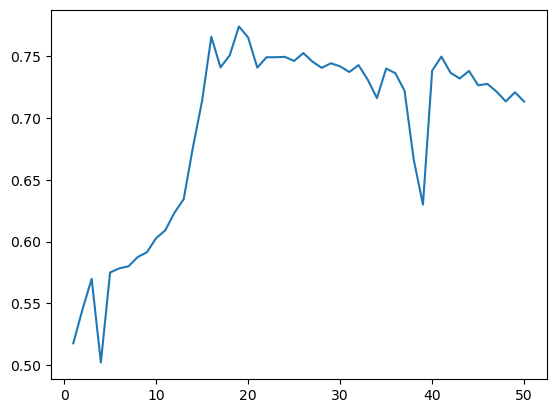

In [58]:
accuracy_epochs = pd.read_csv('simplernn_accuracy.csv')

plt.plot(accuracy_epochs['epoch'], accuracy_epochs['accuracy'])

In [62]:
simpleRNN = tf.keras.models.load_model('simpleRNN.keras')

simpleRNN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 200, 100)          1000000   
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 256)               91392     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1091649 (4.16 MB)
Trainable params: 1091649 (4.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# make predictions and calculate accuracy

y_pred = simpleRNN.predict(x_test)
y_pred = np.round(y_pred)

simple_accuracy = accuracy_score(y_test, y_pred)

782/782 [==============================] - 12s 15ms/step


In [65]:
simple_accuracy

0.68688

## The Need for Attention Mechanism

The problem with basic RNNs is that they are not very good at handling long sequences. 

Even when using more epochs, the accuracy of the model does not improve much. This is because the model is not able to learn the long-term dependencies in the data.

This is known as the vanishing gradient problem.

### Vanishing Gradient Problem

The vanishing gradient problem occurs when the gradients of the loss function become increasingly smaller as the model learns to associate inputs and outputs that are further apart in time.

This leads to the model "forgetting" the information from the earlier inputs, which makes it difficult to learn long-term dependencies.

![Simple RNN](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/SimpleRNN.png)

### Math Behind Vanishing Gradient Problem

The vanishing gradient problem occurs because of the way gradients are computed in RNNs:

$$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial h} \frac{\partial h}{\partial W}
$$

The gradient is computed by multiplying the gradients of the loss function with respect to the output, the output with respect to the hidden state, and the hidden state with respect to the weights.

Since gradients are multiplied together, if the gradients at each time step are less than 1 (e.g., due to using activation functions like sigmoid or tanh), this multiplication leads to a compounding effect. As you go further back in time, the gradients become increasingly smaller.


![Simple RNN](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/SimpleRNNProblem.png)

## Attention Mechanism

To combat the vanishing gradient problem, we can use an attention mechanism.

An attention mechanism is a way to help RNNs learn long-term dependencies by allowing the model to focus on the most relevant parts of the input sequence when producing a given output.

We do this by adding a context vector to the model, which is a weighted sum of the encoder's hidden states. The weights are computed using an alignment score function, which measures how well the inputs around a given position and the output at that position match.

![Attention Mechanism](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/Attention.png)

![Attention Mechanism](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/AttentionLive.png)

By adding an attention mechanism, we can improve the accuracy of our model.

In [19]:
simpleRNN = tf.keras.models.load_model('simpleRNN.keras')

simpleRNN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256)               91392     
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1091649 (4.16 MB)
Trainable params: 1091649 (4.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
from keras.layers import Input, Embedding, LSTM, Dense, Attention, Bidirectional, Dropout, SimpleRNN
import os

inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len)(inputs)
rnn = SimpleRNN(hidden_dim, return_sequences=True)(embedding)
attention = Attention()([rnn, rnn])
context = tf.reduce_sum(attention * rnn, axis=1)
outputs = Dense(output_dim, activation='sigmoid')(context)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding_17 (Embedding)    (None, 200, 100)             1000000   ['input_1[0][0]']             
                                                                                                  
 simple_rnn_17 (SimpleRNN)   (None, 200, 256)             91392     ['embedding_17[0][0]']        
                                                                                                  
 attention_14 (Attention)    (None, 200, 256)             0         ['simple_rnn_17[0][0]',       
                                                                     'simple_rnn_17[0][0]']   

In [37]:
# train the model

model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
157/157 [==============================] - 52s 329ms/step - loss: 0.5564 - accuracy: 0.7442 - val_loss: 0.3591 - val_accuracy: 0.8412
Epoch 2/5
157/157 [==============================] - 47s 303ms/step - loss: 0.2093 - accuracy: 0.9200 - val_loss: 0.3424 - val_accuracy: 0.8656
Epoch 3/5
157/157 [==============================] - 49s 311ms/step - loss: 0.0721 - accuracy: 0.9765 - val_loss: 0.5228 - val_accuracy: 0.8278
Epoch 4/5
157/157 [==============================] - 50s 318ms/step - loss: 0.0323 - accuracy: 0.9905 - val_loss: 0.6208 - val_accuracy: 0.8592
Epoch 5/5
157/157 [==============================] - 50s 316ms/step - loss: 0.0463 - accuracy: 0.9854 - val_loss: 0.4779 - val_accuracy: 0.8546


In [38]:
model.save('simpleRNN_attention.keras')

In [40]:
y_pred = model.predict(x_test)

y_pred = np.round(y_pred)


attention_accuracy = accuracy_score(y_test, y_pred)

attention_accuracy

782/782 [==============================] - 22s 28ms/step


0.82792

By adding an attention mechanism, our model performs way better even when using the low number of epochs.

Text(0, 0.5, 'Accuracy')

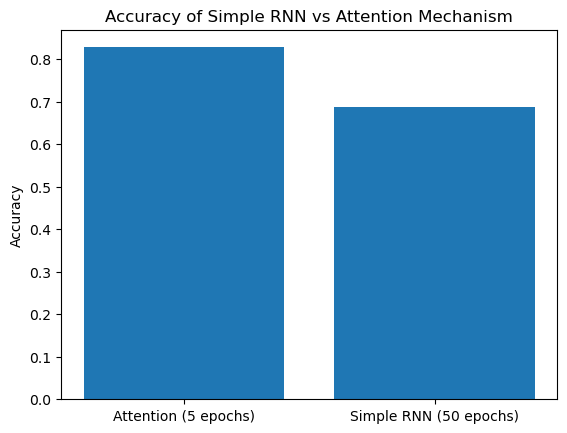

In [66]:
# draw a bar chart to compare the accuracy of the two models

accuracy = [attention_accuracy, simple_accuracy];


plt.bar(['Attention (5 epochs)', 'Simple RNN (50 epochs)'], accuracy)

# add a title to the plot

plt.title('Accuracy of Simple RNN vs Attention Mechanism')

# add a label to the y-axis

plt.ylabel('Accuracy')


In [56]:
# make an interactive example to show how the attention mechanism works

# 1) create a list test cases from the test set

test_cases = x_test[:10]

# 2) create a list of the corresponding labels

labels = y_test[:10]


# make a prediction for a test case and visualize the attention weights

pred = model.predict(test_cases)

weights = model.layers[2].get_weights()[0]
 



1/1 [==============================] - 0s 133ms/step
